Plots go-defense adversary win rate vs. varying victim visits.

In [1]:
%load_ext autoreload
%autoreload 2
import re

import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

# To save space in the body of our paper, we're shrinking
# the height of the plots in this notebook.
FIG_HEIGHT_MULTIPLIER = 0.7

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("2-col-neurips"),
        utils.get_style("small-legend"),
        {
            "ytick.minor.visible": True,
            "ytick.left": True,
            "ytick.right": True,
        },
    ]
)
utils.import_plt_sty("defense-macros.sty")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

In [2]:
# saved figures for combining into one plot later.
visits_figs = [None for _ in range(3)]

In [3]:
def filter_df_for_player(df: pd.DataFrame, player_substring: str):
    """Get df rows matching a player substring."""
    return df[
        (df["b_name"].str.contains(player_substring))
        | (df["w_name"].str.contains(player_substring))
    ].copy()


def get_adv_win_grouped_by_victim_visits(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = "index == index or index != index",
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by victim visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("victim_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi


def plot_victim_visit_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
    victim_label: str,
    custom_ylabel: str | None = None,
    custom_xlabel: str = "Victim visits",
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot performance of A-MCTS-{R,S++} vs. varying victim visits.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
        victim_label: The label to give the victim on the plot.
    """
    fig, ax = plt.subplots(1, 1)

    for df, label in dfs:
        m, l, h = get_adv_win_grouped_by_victim_visits(df)
        m.plot(label=label)
        ax.fill_between(m.index, l, h, alpha=0.3)

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(custom_ylabel or f"Win \\% vs. {victim_label}")
    plt.xlabel(custom_xlabel)
    force_minor_ticks(ax)
    utils.filter_x_minor_ticks()
    if len(dfs) > 1:
        plt.legend()

    return fig, ax

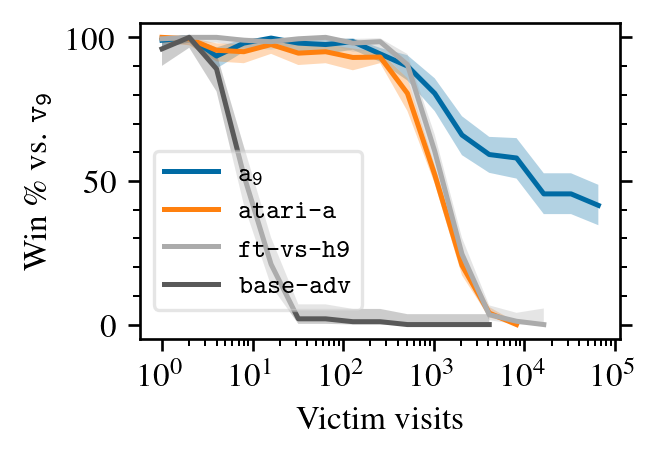

In [40]:
attack_h9_df = utils.parse_sgfs(["/shared/match/ttseng-attack-h9-240314/vs-h9"])
utils.parse_for_match(attack_h9_df, adv_name_regex="attack-h9")

ft_df = utils.parse_sgfs(["/shared/match/ttseng-attack-ft-h9-sweeps-240715/victim-visits"])
utils.parse_for_match(ft_df, adv_name_regex="attack-ft-h9")

r9_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/r9-vs-h9"])
# Only get games against h9
r9_df = filter_df_for_player(r9_df, "h9")
utils.parse_for_match(r9_df, adv_name_regex="r9")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-1"])
# Only get games against h9
original_cyclic_df = filter_df_for_player(original_cyclic_df, "h9")
utils.parse_for_match(original_cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        (r9_df, r"\attackiter{9}"),
        (attack_h9_df, r"\attackhnineshort{}"),
        (ft_df, r"\fthnine{}"),
        (original_cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\defenseiter{9}",
)
# Move legend and make transparent to increase visibility of plot lines
ax.legend(loc="lower left", bbox_to_anchor=(0, 0.05)).get_frame().set_alpha(0.5)
fig.savefig("vs-visits-h9.pgf", backend="pgf")
visits_figs[1] = (fig, ax)

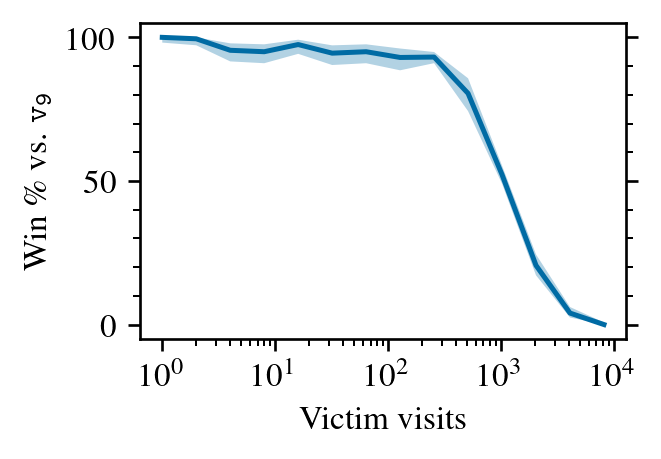

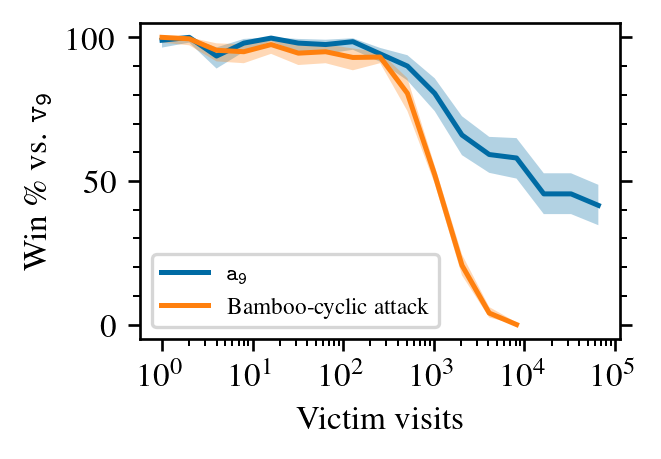

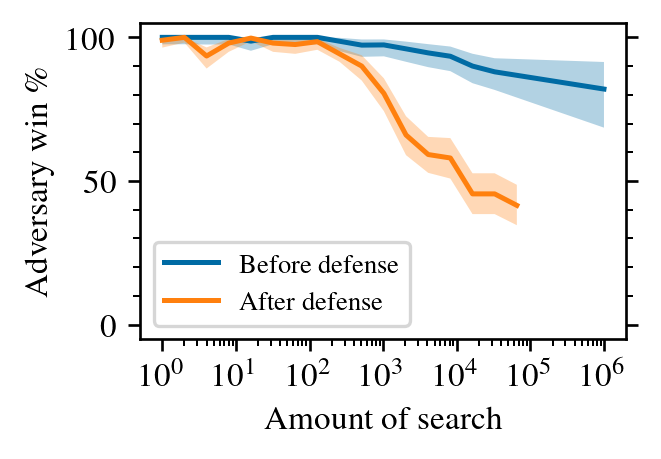

In [17]:
# Presentation plots
plot_victim_visit_sweep(
    [
        (attack_h9_df, r"\attackhnine{}"),
    ],
    r"\defenseiter{9}",
)
fig, ax = plot_victim_visit_sweep(
    [
        (r9_df, r"\attackiter{9}"),
        (attack_h9_df, "Bamboo-cyclic attack"),
    ],
    r"\defenseiter{9}",
)
ax.legend(prop={"size": 7})
fig.savefig("/tmp/simpler-visits-vs-h9.svg")

cyclic_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-victim-v-sweep-amcts-sxx-20230117-235656",
        "/shared/match/s545mil-v600-vs-cp505-v1mil",
        # games against cp505-v10mil are on Hofvarpnir and aren't accessible
    ]
)
utils.parse_for_match(cyclic_df, adv_name_regex="adv")
plot_victim_visit_sweep(
    [
        (cyclic_df, "Before defense"),
        (r9_df, "After defense"),
    ],
    "",
    custom_ylabel=r"Adversary win \%",
    custom_xlabel=r"Amount of search",
);

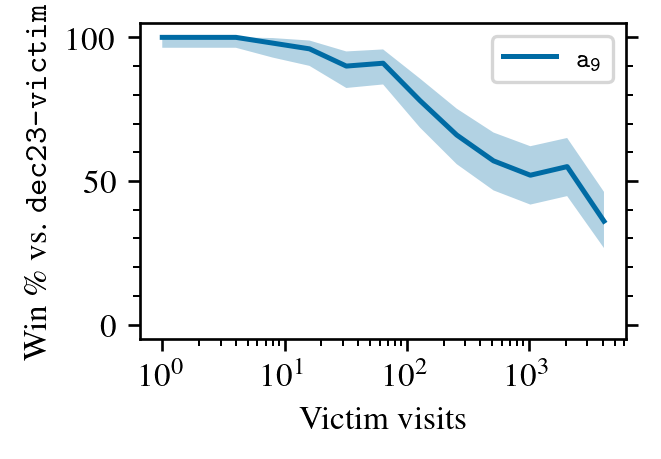

In [18]:
r9_df = utils.parse_sgfs(["/shared/match/paper-robustness/transfer/rs-vs-b18/r9"])
utils.parse_for_match(r9_df, adv_name_regex="r9")

fig, ax = plot_victim_visit_sweep(
    [
        (r9_df, r"\attackiter{9}"),
    ],
    r"\dectwentythree{}",
)
ax.legend()
fig.savefig("transfer-r9-vs-b18-visits.pgf", backend="pgf")

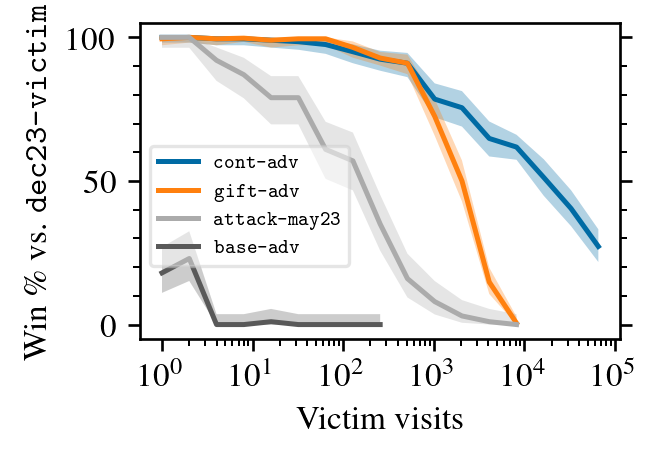

In [19]:
cont_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-upto-v4096",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v8192-and-b60",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v16k-to-65k",
    ]
)
cont_df = filter_df_for_player(cont_df, "b18")
utils.parse_for_match(cont_df, adv_name_regex="cont")

ko_df = utils.parse_sgfs(["/shared/match/ttseng-attack-b18-240417/victim-visits"])
utils.parse_for_match(ko_df, adv_name_regex="attack-b18")

cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-cont-vs-b18-s8527m-240311/cyclic"])
utils.parse_for_match(cyclic_df, adv_name_regex="r0-v600")

attack_b60_df = utils.parse_sgfs(
    ["/shared/match/ttseng-cont-vs-b18-s8527m-240311/attack-b60"]
)
utils.parse_for_match(attack_b60_df, adv_name_regex="attack-b60")

fig, ax = plot_victim_visit_sweep(
    [
        (cont_df, r"\contadvmedium{}"),
        (ko_df, r"\koadvmedium{}"),
        (attack_b60_df, r"\attackbsixty{}"),
        (cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\dectwentythree{}",
)
ax.legend(
    loc="lower left", bbox_to_anchor=(0, 0.2), prop={"size": 6}
).get_frame().set_alpha(0.5)
fig.savefig("vs-visits-b18.pgf", backend="pgf")
visits_figs[0] = (fig, ax)

In [42]:
large_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-large-adv-240715/victim-visits/2",
        "/shared/match/ttseng-large-adv-240715/victim-visits/3",
    ]
)
utils.parse_for_match(large_df, adv_name_regex="large")

cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-large-adv-240715/orig-cyclic-vs-b18-s9997m"])
utils.parse_for_match(cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        (large_df, r"\largeadv{}"),
        (cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\maytwentyfour{}",
)
ax.legend()
fig.savefig("vs-visits-b18-s9997.pgf", backend="pgf")

AttributeError: 'DataFrame' object has no attribute 'b_name'

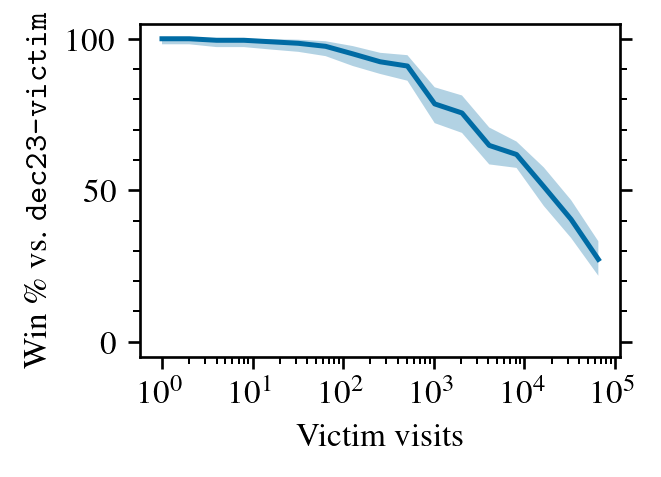

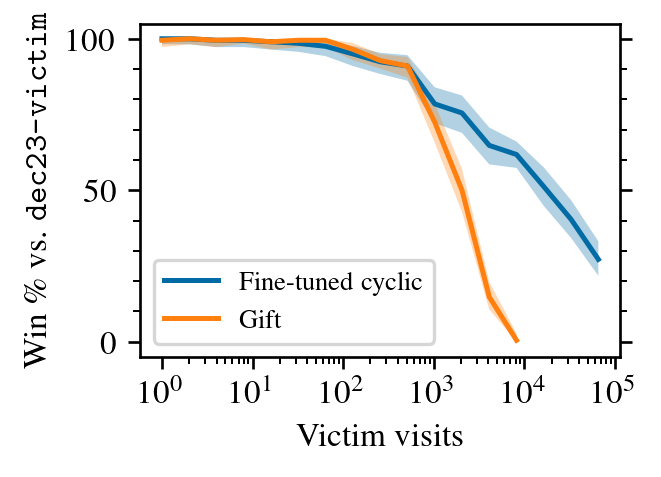

In [20]:
# Presentation plots
# Increase height slightly to make y label fit.
fig_width, fig_height = plt.rcParams["figure.figsize"]
with plt.style.context({"figure.figsize": (fig_width, max(fig_height, 1.8725))}):
    plot_victim_visit_sweep(
        [
            (cont_df, r"Fine-tuned cyclic"),
        ],
        r"\dectwentythree{}",
    )
    fig, _ = plot_victim_visit_sweep(
        [(cont_df, r"Fine-tuned cyclic"), (ko_df, r"Gift")],
        r"\dectwentythree{}",
    )
    fig.savefig("/tmp/simpler-visits-vs-b18.svg")

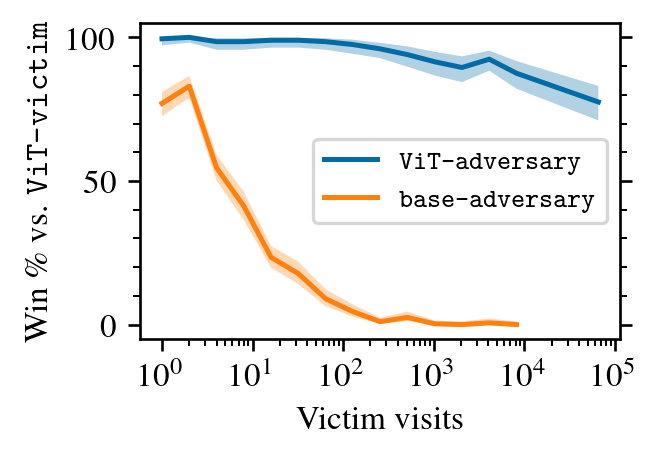

In [21]:
attack_vit_df = utils.parse_sgfs(
    ["/shared/match/ttseng-attack-vit-240311/v1-to-v8192-and-v65536"]
)
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-vitb16-vs-cyclic"])
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversary{}"),
        (original_cyclic_df, r"\origcyclic{}"),
    ],
    r"\vitvictim{}",
)
fig.savefig("vs-visits-vit.pgf", backend="pgf")
visits_figs[2] = (fig, ax)

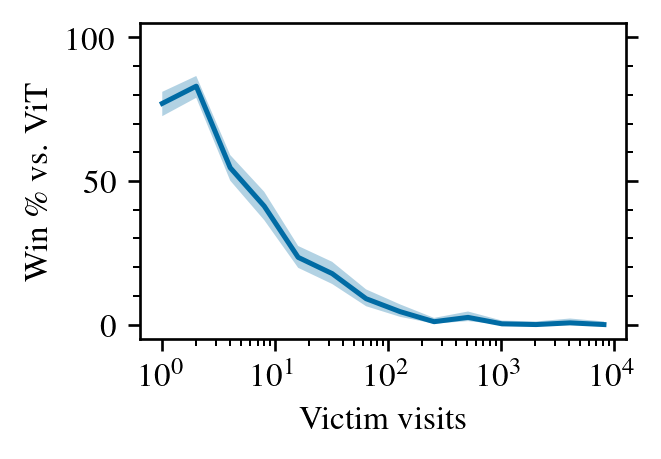

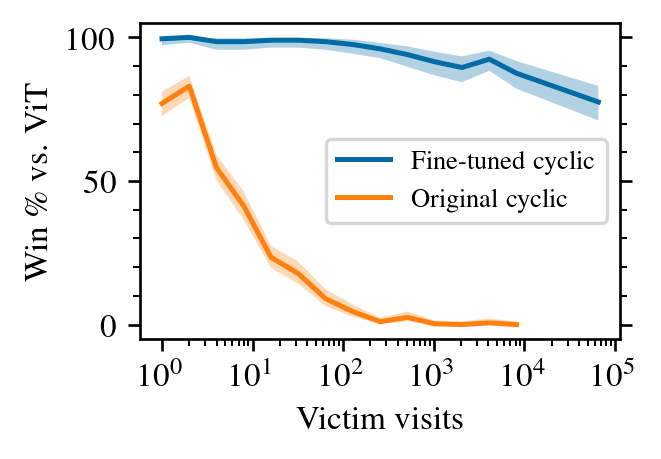

In [22]:
# Presentation plots
plot_victim_visit_sweep(
    [
        (original_cyclic_df, r"Original cyclic"),
    ],
    r"ViT",
)
fig, _ = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"Fine-tuned cyclic"),
        (original_cyclic_df, r"Original cyclic"),
    ],
    r"ViT",
)
fig.savefig("/tmp/simpler-visits-vs-vit.svg")

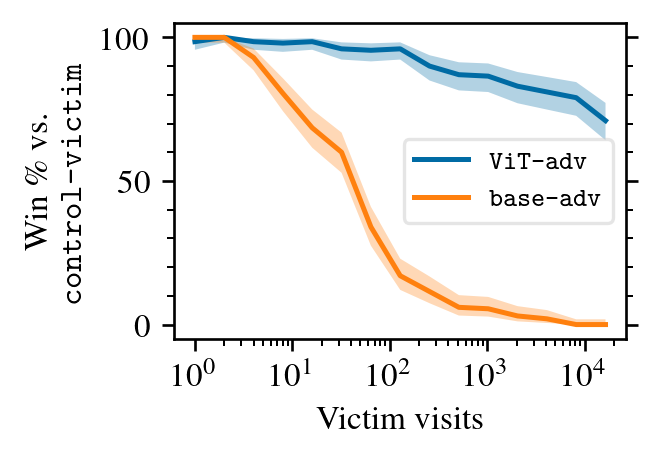

In [23]:
df = utils.parse_sgfs(["/shared/match/attack-b10-240311"])
attack_vit_df = filter_df_for_player(df, "attack-vit")
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")
original_cyclic_df = filter_df_for_player(df, "cyclic")
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversarymedium{}"),
        (original_cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\controlbten{}",
    custom_ylabel="Win \\% vs.\n\\controlbten{}",
)
ax.legend().get_frame().set_alpha(0.5)
fig.savefig("vs-visits-control-b10.pgf", backend="pgf")

/tmp/ipykernel_427/342194996.py:81: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05)


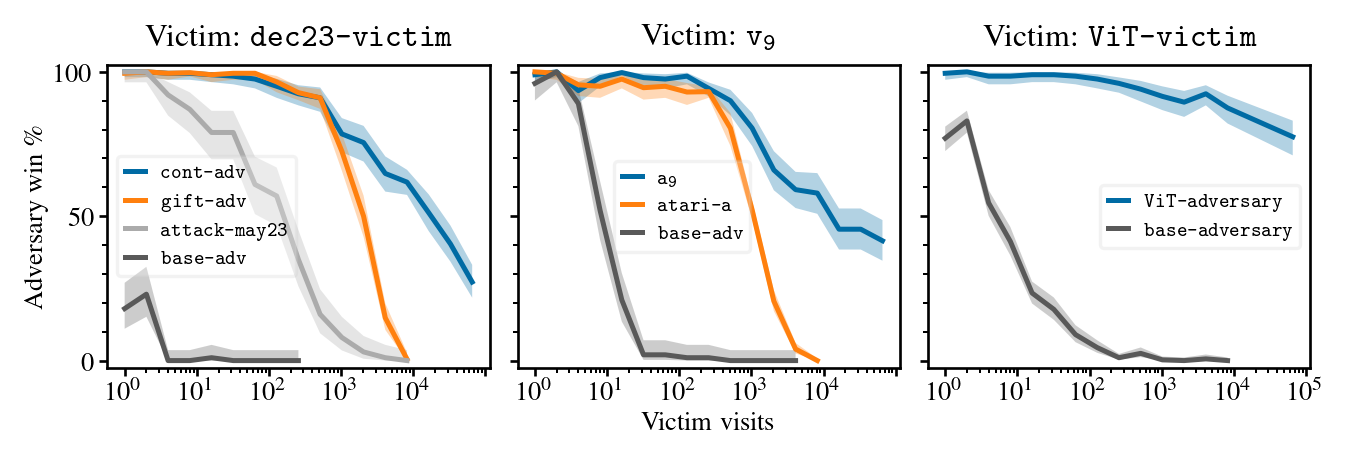

In [24]:
# Combine the main figures into one row, to save space in
# body of the paper
orig_figsize = plt.rcParams["figure.figsize"]
one_col_width = orig_figsize[0] / 0.48
extra_style = {
    "figure.figsize": (one_col_width, orig_figsize[1]),
    "font.size": 8,
    "legend.fontsize": 6,
    "axes.labelpad": 2,
    "ytick.right": False,
}
for c in ["x", "y"]:
    extra_style.update(
        {
            f"{c}tick.major.size": 2.4,
            f"{c}tick.minor.size": 1.5,
            f"{c}tick.major.pad": 1.5,
            f"{c}tick.minor.pad": 1.4,
            f"{c}tick.minor.visible": True,
        }
    )

with plt.style.context(extra_style):
    fig, axs = plt.subplots(1, 3, sharey=True)
    for i, (ax, (_, old_ax)) in enumerate(zip(axs, visits_figs)):
        confidence_intervals = [
            x
            for x in old_ax.get_children()
            if isinstance(x, matplotlib.collections.PolyCollection)
        ]
        for line, ci in zip(old_ax.get_lines(), confidence_intervals):
            label = line.get_label()
            is_base_adv = "origcyclic" in label
            # Give origcyclic the same color across all plots for consistency
            color = COLORS[3] if "origcyclic" in label else line.get_color()

            xs, ys = line.get_data()
            ax.plot(xs, ys, label=line.get_label(), color=color)

            ci_polygon = ci.get_paths()[0].vertices
            # CI is a polygon, first tracing left-to-right along the bottom of the CI
            # and then right-to-left along the top of the CI, with a few duplicate points
            # at the extremal x points.
            low_ci = ci_polygon[: len(ci_polygon) // 2]
            xs = low_ci[:, 0]
            low_ys = low_ci[:, 1]
            high_ci = ci_polygon[-len(xs) :][::-1]
            assert np.array_equal(high_ci[:, 0], xs)
            high_ys = high_ci[:, 1]
            ax.fill_between(xs, low_ys, high_ys, facecolor=color, alpha=ci.get_alpha())

        victim = old_ax.get_ylabel().removeprefix("Win \% vs. ")
        ax.set_title(f"Victim: {victim}")
        ax.set_xscale("log")
        ax.set_ylim(-2.5, 102.5)
        ax.legend(
            handlelength=1,
            # manually adjust legend position for v9 plot
            loc="lower left" if i == 1 else None,
            bbox_to_anchor=(0.225, 0.35) if i == 1 else None,
        ).get_frame().set_alpha(0.25)

        # Force more major x-ticks
        _, max_x = ax.get_xlim()
        max_x_tick_log = int(np.floor(np.log10(max_x)))
        ax.set_xticks(np.logspace(0, max_x_tick_log, max_x_tick_log + 1))
        if i < len(axs) - 1:
            # Cut off last x-tick label because it crowds the first x-tick
            # of the next plot to its right.
            labels = [label.get_text() for label in ax.get_xticklabels()]
            labels[-1] = ""
            ax.set_xticklabels(labels)

        force_minor_ticks(ax)
        utils.filter_x_minor_ticks(ax)

    axs[0].set_ylabel("Adversary win \%")
    axs[1].set_xlabel("Victim visits")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig("vs-visits-combined.pgf", backend="pgf")